# Wiremind data science test

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import graphviz
import post_processing

from scipy.stats import uniform, lognorm
from matplotlib import rcParams

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, median_absolute_error, r2_score, mean_squared_error, mean_squared_log_error
from sklearn.dummy import DummyRegressor
rcParams.update({'font.size': 14})

# Pre-processing

In [2]:
# Load the dataset
df = pd.read_csv('ds_train.csv')

In [3]:
# Split between data and target
data = df.drop(columns=['demand'])
label = df['demand']

In [4]:
# Create test and train
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=123456)

In [5]:
# Define final evaluation metrics
evaluation_metrics = [max_error, mean_absolute_error, median_absolute_error, mean_squared_log_error, r2_score]

In [6]:
# Simple regressor to have a baseline for the evaluation metrics
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(x_train, y_train)
y_pred_dummy = dummy_regr.predict(x_test)

post_processing.eval_model(y_test, y_pred_dummy, evaluation_metrics)

max_error: 139.0
mean_absolute_error: 1.3423201776866565
median_absolute_error: 0.0
mean_squared_log_error: 0.7343926990223019
r2_score: -0.13505520146206185


## First model : Minimizing the squared log loss with xgboost using decision trees as weak learners


In [9]:
# Feature design, we just drop useless columns and encode the categorical variable

feature_crafting = ColumnTransformer(
    [
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['direction']),
        ('drop', 'drop', ['departure_date', 'train_number', 'od_destination_time_year'])
    ], remainder='passthrough')

In [8]:
# Pipeline with a gradient boosting model, we minimize the squared log error

pipe_msle = Pipeline([
    ('feature_craft', feature_crafting),
    ('xgb', xgb.XGBRegressor(objective='reg:squaredlogerror')),
])

In [9]:
pipe_msle.fit(x_train, y_train)
y_pred = pipe_msle.predict(x_test)

post_processing.eval_model(y_test, y_pred, evaluation_metrics)

max_error: 127.02556133270264
mean_absolute_error: 0.8589894755811706
median_absolute_error: 0.2820447236299515
r2_score: 0.7089597006416775


In [10]:
# As we try to predict positive integer variables a simple rounding greatly improves the mean absolute error and the median absolute error, we also set negative predictions to zero
# Maybe it is better to use a model that is able to internally take this constraint into account

y_pred = post_processing.round_prediction(y_pred)
post_processing.eval_model(y_test, y_pred, evaluation_metrics)

max_error: 127.0
mean_absolute_error: 0.7900905518537502
median_absolute_error: 0.0
mean_squared_log_error: 0.2332455467303628
r2_score: 0.7029471975161228


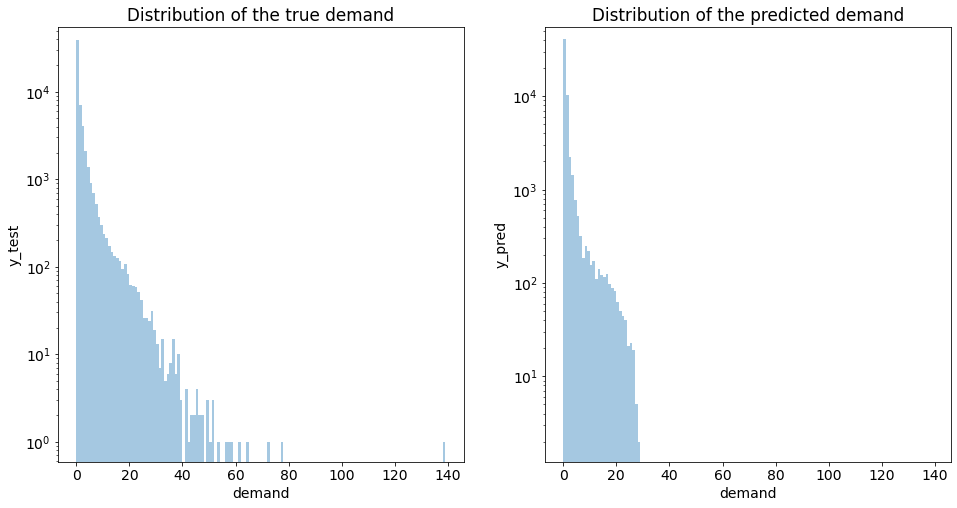

In [11]:
# Look at the distribution of the predicted demand
post_processing.demand_distrib(y_test, y_pred)

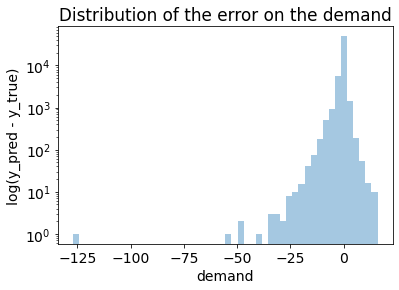

In [12]:
# Look at the distribution of errors
post_processing.error_distrib(y_test, y_pred)

## Second model : Minimizing the squared loss on the log-transformed target with xgboost using decision trees as weak learners

In [7]:
# Instead of minimizing the mean squared log error, let us fit the model on the log-transformed target.
class CustomTargetTransformer(BaseEstimator, TransformerMixin):
  
  def fit(self, target):
    return self

  def transform(self, target):
    return np.log(target + 1)

  def inverse_transform(self, target):
    return np.exp(target) - 1

In [10]:
# With the transformed data, we just minimize the mean squared error
pipe_mse = Pipeline([
    ('feature_craft', feature_crafting),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror')),
])
model = TransformedTargetRegressor(regressor=pipe_mse, 
                                   transformer=CustomTargetTransformer(),
                                   check_inverse=False)

In [15]:
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
post_processing.eval_model(y_test, y_pred, evaluation_metrics)

max_error: 119.73391914367676
mean_absolute_error: 0.836842650475511
median_absolute_error: 0.2798255681991577
r2_score: 0.7386878342010277


In [16]:
y_pred = post_processing.round_prediction(y_pred)
post_processing.eval_model(y_test, y_pred, evaluation_metrics)

max_error: 120.0
mean_absolute_error: 0.7689560908935589
median_absolute_error: 0.0
mean_squared_log_error: 0.22949052070875098
r2_score: 0.7326307072107847


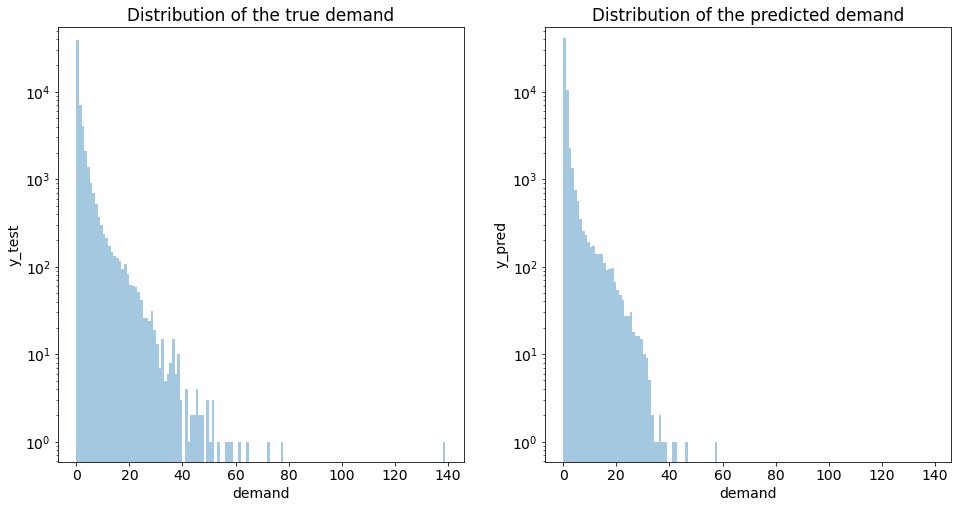

In [17]:
# Look at the distribution of the predicted demand
post_processing.demand_distrib(y_test, y_pred)

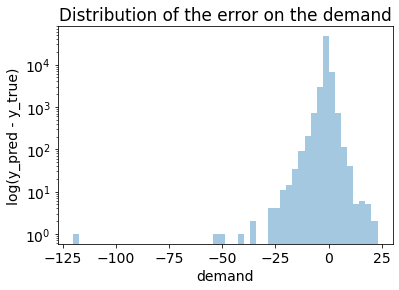

In [18]:
# Look at the distribution of errors
post_processing.error_distrib(y_test, y_pred)

The second model, which does the regression on the log of the demand performs better than the first one in all evaluation metrics we consider.

# Hyperparameter tuning

Let us do a quick tuning of the parameters of the second model to improve the performance.

In [19]:
# Define the search space for parameters
param_grid = {
    'regressor__xgb__learning_rate': uniform(),
    'regressor__xgb__max_depth': [3, 5, 10],
    'regressor__xgb__n_estimators': [10, 100, 500],
    'regressor__xgb__reg_lambda': lognorm(1)
}

In [20]:
# Search for some good hyperparameters, n_iter is kept low so that the running time is not too high (still 20 minutes...), a larger n_iter should be chosen for efficiency of the procedure.

grid = RandomizedSearchCV(model, param_grid, cv=5, n_iter=10, random_state=123)
model_tuned = grid.fit(x_train, y_train)

print('Learning rate {}'.format(grid.best_estimator_.regressor_['xgb'].learning_rate))
print('Max depth: {}'.format(grid.best_estimator_.regressor_['xgb'].max_depth))
print('Number of trees {}'.format(grid.best_estimator_.regressor_['xgb'].n_estimators))
print('Reg lambda {}'.format(grid.best_estimator_.regressor_['xgb'].reg_lambda))

Learning rate 0.41092437270901894
Max depth: 5
Number of trees 500
Reg lambda 0.7509235192444327


In [21]:
y_tuned_pred = grid.predict(x_test)
post_processing.eval_model(y_test, y_tuned_pred, evaluation_metrics)

max_error: 120.11898612976074
mean_absolute_error: 0.8300102292992367
median_absolute_error: 0.2814510464668274
r2_score: 0.7466684862569792


In [22]:
y_tuned_pred = post_processing.round_prediction(y_tuned_pred)
post_processing.eval_model(y_test, y_tuned_pred, evaluation_metrics)

max_error: 120.0
mean_absolute_error: 0.7641038783529813
median_absolute_error: 0.0
mean_squared_log_error: 0.22773308292028985
r2_score: 0.7406806896060841


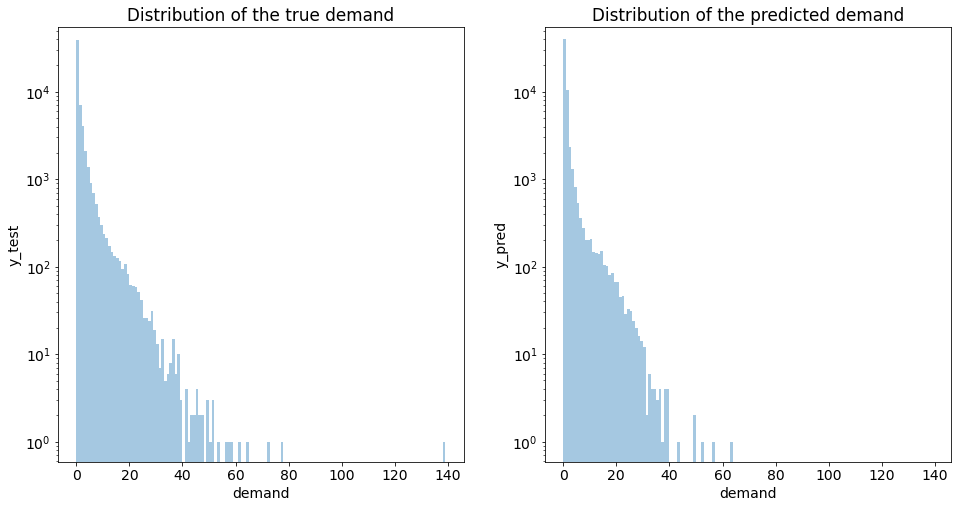

In [23]:
# Look at the distribution of the predicted demand
post_processing.demand_distrib(y_test, y_tuned_pred)

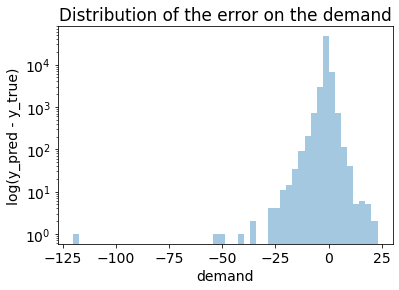

In [24]:
# Look at the distribution of errors
post_processing.error_distrib(y_test, y_pred)